In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
import matplotlib.image as img

2025-03-06 18:50:46.305983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741287046.400306   58350 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741287046.426070   58350 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 18:50:46.657253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


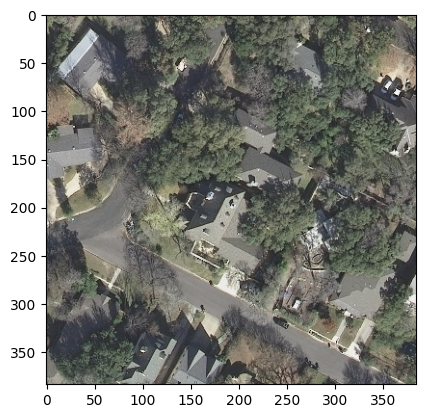

In [40]:
test_image = cv2.imread('./AerialImageDataset/train_384x384/images/austin6_1_11.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = resize(test_image,(384,384,3))
plt.imshow(test_image, cmap='gray')
plt.show()

In [5]:
model_path = './models/model_85.keras'
model = tf.keras.models.load_model(model_path)

I0000 00:00:1741287077.024704   58350 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:0a:00.0, compute capability: 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


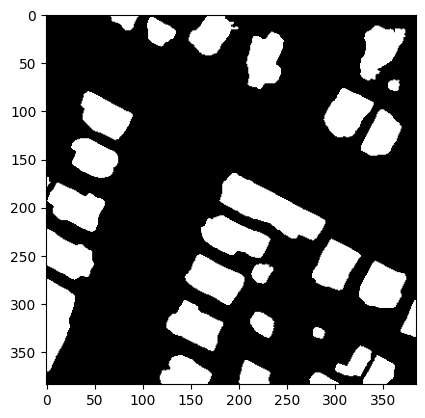

In [ ]:
mask = model.predict(np.expand_dims(test_image, 0))
mask= mask.reshape(384,384)*255
plt.imshow(mask, cmap='gray')
ret, pred = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)
plt.imshow(pred, cmap='gray')
    

In [29]:
def create_aggregated_mask(binary_mask, kernel_size, flood_fill=False):
    # Save the initial binary mask
    cv2.imwrite('binary_mask.png', binary_mask)

    # Create a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing operation to fill small holes and aggregate mask
    aggregated_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cv2.imwrite('aggregated_mask_after_closing.png', aggregated_mask)

    # Apply morphological erosion to remove noise
    aggregated_mask = cv2.erode(aggregated_mask, kernel, iterations=1)
    cv2.imwrite('aggregated_mask_after_erosion.png', aggregated_mask)

    # Apply morphological dilation to enhance object boundaries
    aggregated_mask = cv2.dilate(aggregated_mask, kernel, iterations=1)
    cv2.imwrite('aggregated_mask_after_dilation.png', aggregated_mask)

    if flood_fill:
        # Create a mask for flood filling with a border of 2 pixels
        flood_fill_mask = np.zeros((aggregated_mask.shape[0] + 2, aggregated_mask.shape[1] + 2), np.uint8)

        # Flood fill the mask starting from a seed point
        cv2.floodFill(aggregated_mask, flood_fill_mask, (0, 0), 255)
        cv2.imwrite('aggregated_mask_after_flood_fill.png', aggregated_mask)

        # Invert the flood-filled mask
        inverted_flood_fill = cv2.bitwise_not(flood_fill_mask[1:-1, 1:-1])
        cv2.imwrite('inverted_flood_fill.png', inverted_flood_fill)

        # Ensure the dimensions match before combining
        aggregated_mask = cv2.resize(aggregated_mask, (inverted_flood_fill.shape[1], inverted_flood_fill.shape[0]))

        # Convert aggregated_mask to uint8
        aggregated_mask = aggregated_mask.astype(np.uint8)

        # Combine the aggregated mask with the flood-filled mask
        aggregated_mask = cv2.bitwise_or(aggregated_mask, inverted_flood_fill)
        cv2.imwrite('aggregated_mask_after_combining.png', aggregated_mask)

    


In [30]:
# Ensure mask is of type uint8
mask = mask.astype(np.uint8)

# Create the aggregated mask
kernel_size = 5
flood_fill = True

aggregated_mask = create_aggregated_mask(mask, kernel_size, flood_fill)
cv2.imwrite('aggregated_mask.png', aggregated_mask)


error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [13]:
# Example usage
threshold_value = 125
kernel_size = 3
flood_fill = True

mask = create_aggregated_mask(mask, threshold_value, kernel_size, flood_fill)
cv2.imwrite('aggregated_mask.png', mask)

True

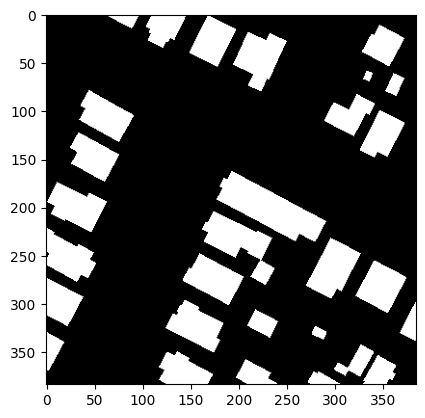

In [34]:
from skimage.color import rgb2gray
gt = cv2.imread('./AerialImageDataset/train_384x384/gt/austin20_1_1.png')
gt = resize(gt,(384,384,3))

gt = rgb2gray(gt)
plt.imshow(gt, cmap='gray')
plt.show()

In [35]:
intersection = np.logical_and(gt, pred)
union = np.logical_or(gt, pred)
iou_score = np.sum(intersection) / np.sum(union)

In [36]:
iou_score

np.float64(0.8246285760509073)

Total Pixel Area: 32094.5


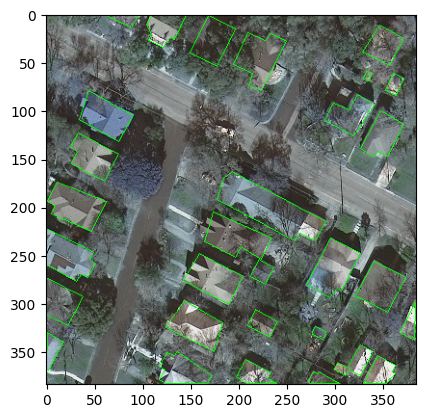

In [38]:
# Load the binary mask image
binary_mask = gt
area_list = []

# Check if the binary mask image is loaded correctly
if binary_mask is None:
    raise ValueError("Binary mask image not found at the specified path.")

# Convert binary mask to CV_8UC1 format
binary_mask = (binary_mask * 255).astype(np.uint8)

# Find contours of the white pixels
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Load the original image (assuming the same size as the binary mask)
original_image_path ='./AerialImageDataset/train_384x384/images/austin20_1_1.jpg'
original_image = cv2.imread(original_image_path)
# original_image = resize(original_image,(384,384,3))

# Check if the original image is loaded correctly
if original_image is None:
    raise ValueError("Original image not found at the specified path.") 

# Ensure the original image is in the correct format for display
if len(original_image.shape) == 2:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# Draw polygons around the detected contours and calculate areas
for contour in contours:
    # Approximate the contour to reduce the number of points
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(original_image, [approx], -1, (0, 255, 0), 1)
    
    # Calculate the area in pixel units
    pixel_area = cv2.contourArea(contour)
    area_list.append(pixel_area)

    
    # Print or store the area values as needed
    # print(f"Pixel Area: {pixel_area}")
print(f"Total Pixel Area: {sum(area_list)}")
# Save the image with traced rooftops
# output_path = '_output_image.png'
# cv2.imwrite(output_path, original_image)

# Optionally, display the image with traced rooftops
# cv2.imshow('Detected Rooftops', original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(original_image, cmap='gray')
plt.show()


In [47]:
image_path = 'AerialImageDataset/train_384x384/images/austin9_9_3.jpg'

In [35]:
def create_aggregated_mask_and_bounding_boxes(binary_mask, kernel_size):
    # Save the initial binary mask
    cv2.imwrite('binary_mask.png', binary_mask)

    # Create a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing operation to fill small holes and aggregate mask
    aggregated_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cv2.imwrite('aggregated_mask_after_closing.png', aggregated_mask)

    # Apply morphological erosion to remove noise
    aggregated_mask = cv2.erode(aggregated_mask, kernel, iterations=1)
    cv2.imwrite('aggregated_mask_after_erosion.png', aggregated_mask)

    # Apply morphological dilation to enhance object boundaries
    aggregated_mask = cv2.dilate(aggregated_mask, kernel, iterations=1)
    cv2.imwrite('aggregated_mask_after_dilation.png', aggregated_mask)

    # Find contours in the aggregated mask
    contours, _ = cv2.findContours(aggregated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the bounding boxes
    bounding_box_mask = np.zeros_like(aggregated_mask)

    # Draw bounding boxes around each contour
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(bounding_box_mask, (x, y), (x + w, y + h), 255, 2)

    cv2.imwrite('bounding_box_mask.png', bounding_box_mask)

    return bounding_box_mask

# Ensure mask is of type uint8
mask = mask.astype(np.uint8)

# Create the aggregated mask and draw bounding boxes
kernel_size = 5

bounding_box_mask = create_aggregated_mask_and_bounding_boxes(mask, kernel_size)
cv2.imwrite('final_bounding_box_mask.png', bounding_box_mask)


True

MAPS API

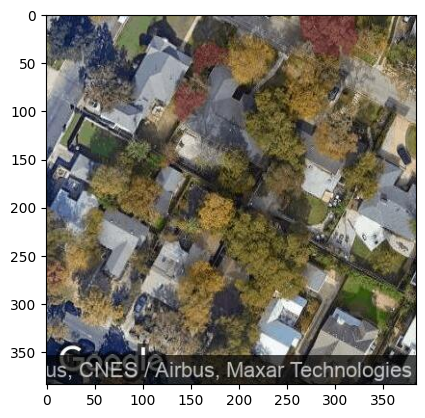

In [27]:
maps_image = cv2.imread('map_image.jpg')
maps_image = cv2.cvtColor(maps_image, cv2.COLOR_BGR2RGB)
maps_image = resize(maps_image,(384,384,3))
plt.imshow(maps_image, cmap='gray')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


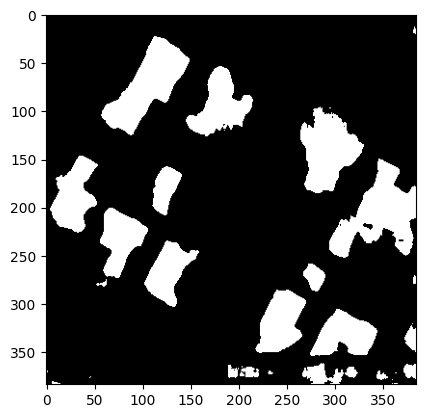

In [28]:
maps_mask = model.predict(np.expand_dims(maps_image, 0))
maps_mask= maps_mask.reshape(384,384)*255
plt.imshow(maps_mask, cmap='gray')
ret, pred = cv2.threshold(maps_mask, 125, 255, cv2.THRESH_BINARY)
plt.imshow(pred, cmap='gray')

Total Pixel Area: 26643.0


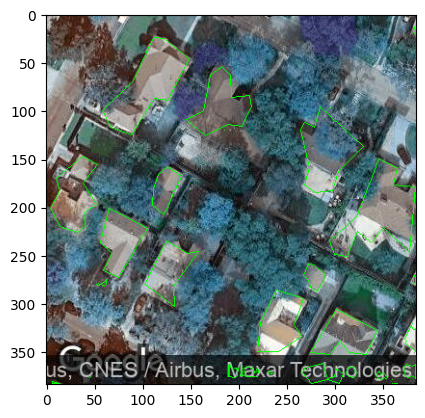

In [29]:
# Load the binary mask image
binary_mask = pred
area_list = []

# Check if the binary mask image is loaded correctly
if binary_mask is None:
    raise ValueError("Binary mask image not found at the specified path.")

# Convert binary mask to CV_8UC1 format
binary_mask = (binary_mask * 255).astype(np.uint8)

# Find contours of the white pixels
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Load the original image (assuming the same size as the binary mask)
original_image_path ='map_image.jpg'
original_image = cv2.imread(original_image_path)
# original_image = resize(original_image,(384,384,3))

# Check if the original image is loaded correctly
if original_image is None:
    raise ValueError("Original image not found at the specified path.") 

# Ensure the original image is in the correct format for display
if len(original_image.shape) == 2:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# Draw polygons around the detected contours and calculate areas
for contour in contours:
    # Approximate the contour to reduce the number of points
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(original_image, [approx], -1, (0, 255, 0), 1)
    
    # Calculate the area in pixel units
    pixel_area = cv2.contourArea(contour)
    area_list.append(pixel_area)

    
    # Print or store the area values as needed
    # print(f"Pixel Area: {pixel_area}")
print(f"Total Pixel Area: {sum(area_list)}")
# Save the image with traced rooftops
# output_path = '_output_image.png'
# cv2.imwrite(output_path, original_image)

# Optionally, display the image with traced rooftops
# cv2.imshow('Detected Rooftops', original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(original_image, cmap='gray')
plt.show()